<a href="https://colab.research.google.com/github/VEVELANDIA/Prueba-DataScientist-VictorVelandia/blob/main/Prueba_de_Conocimiento_Datos_Estructurados_%5BV%C3%ADctor_Velandia%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
%%capture

#@title **Librerias**: Se instalan los paquetes e importan librerias necesarias para poder tomar los insumos desde Drive y para desarrollar el modelo predictivo
!pip install -U -q PyDrive
# !pip install --upgrade -q gspread
!pip install --upgrade xlrd
!pip install --upgrade -q pandas
!pip install -q openpyxl
!pip install gspread==5.1.1
!pip install -q xlsxwriter
!pip install pyxlsb
from google.colab import files
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
import numpy    as np
import pandas   as pd
import datetime as dt
import gspread
from google.colab import auth
from google.auth import default
from openpyxl import load_workbook
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from pandas.tseries.offsets import MonthEnd
from oauth2client.client import GoogleCredentials
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

creds, _ = default()
gc = gspread.authorize(creds)

In [32]:
#@title **Traer datos de entrenamiento**

# cuando es un archivo de csv se utiliza este codigo
downloaded = drive.CreateFile({'id': '1LJr7EpiG2meK3cp1YHvGMYqNonVqaYcX'}) # replace the id with id of file you want to access
downloaded.GetContentFile('train_precios_vivienda.csv')
Precios_train= pd.read_csv('train_precios_vivienda.csv',dtype={'fecha_aprobación': str})
Precios_train

,Unnamed: 0,id,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,barrio,sector,direccion_inmueble_informe,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,estrato,barrio_legal,topografia_sector,condiciones_salubridad,transporte,demanda_interes,paradero,alumbrado,arborizacion,alamedas,ciclo_rutas,nivel_equipamiento_comercial,descripcion_general_sector,perspectivas_de_valorizacion,actualidad_edificadora,comportamiento_oferta_demanda,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,telefono_en_el_predio,tipo_inmueble,descripcion_tipo_inmueble,uso_actual,descripcion_uso_inmueble,clase_inmueble,descripcion_clase_inmueble,ocupante,sometido_a_propiedad_horizontal,altura_permitida,observaciones_altura_permitida,aislamiento_posterior,observaciones_aislamiento_posterior,aislamiento_lateral,observaciones_aislamiento_lateral,antejardin,observaciones_antejardin,indice_ocupacion,observaciones_indice_ocupacion,indice_construccion,observaciones_indice_construccion,predio_subdividido_fisicamente,unidades,contadores_agua,contadores_luz,accesorios,area_valorada,observaciones_generales_inmueble,condicion_ph,numero_piso,numero_de_edificios,area_actividad,uso_principal_ph,rph,porteria,citofono,bicicletero,piscina,tanque_de_agua,club_house,garaje_visitantes,teatrino,sauna,vigilancia_privada,tipo_vigilancia,administracion,vetustez,pisos_bodega,estructura,ajustes_sismoresistentes,cubierta,fachada,tipo_fachada,estructura_reforzada,danos_previos,material_de_construccion,detalle_material,iluminacion,ventilacion,irregularidad_planta,irregularidad_altura,observaciones_estructura,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,observaciones_dependencias,estado_acabados_pisos,calidad_acabados_pisos,estado_acabados_muros,calidad_acabados_muros,estado_acabados_techos,calidad_acabados_techos,estado_acabados_madera,calidad_acabados_madera,estado_acabados_metal,calidad_acabados_metal,estado_acabados_banos,calidad_acabados_banos,estado_acabados_cocina,calidad_acabados_cocina,tipo_garaje,numero_total_de_garajes,total_cupos_parquedaro,numero_garaje_1,matricula_garaje_1,garaje_cubierto_1,garaje_doble_1,garaje_paralelo_1,garaje_servidumbre_1,numero_garaje_2,matricula_garaje_2,garaje_cubierto_2,garaje_doble_2,garaje_paralelo_2,garaje_servidumbre_2,numero_garaje_3,matricula_garaje_3,garaje_cubierto_3,garaje_doble_3,garaje_paralelo_3,garaje_servidumbre_3,numero_garaje_4,matricula_garaje_4,garaje_cubierto_4,garaje_doble_4,garaje_paralelo_4,garaje_servidumbre_4,numero_garaje_5,matricula_garaje_5,garaje_cubierto_5,garaje_doble_5,garaje_paralelo_5,garaje_servidumbre_5,tipo_deposito,numero_total_depositos,numero_deposito_1,matricula_inmobiliaria_deposito_1,numero_deposito_2,matricula_inmobiliaria_deposito_2,numero_deposito_3,matricula_inmobiliaria_deposito_3,numero_deposito_4,matricula_inmobiliaria_deposito_4,numero_deposito_5,matricula_inmobiliaria_deposito_5,observaciones_generales_construccion,metodo_valuacion_1,concepto_del_metodo_1,metodo_valuacion_2,concepto_del_metodo_2,metodo_valuacion_3,concepto_del_metodo_3,metodo_valuacion_4,concepto_del_metodo_4,metodo_valuacion_5,concepto_del_metodo_5,metodo_valuacion_6,concepto_del_metodo_6,metodo_valuacion_7,concepto_del_metodo_7,metodo_valuacion_8,concepto_del_metodo_8,metodo_valuacion_9,concepto_del_metodo_9,area_privada,valor_area_privada,area_garaje,valor_area_garaje,area_deposito,valor_area_deposito,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,4112,5896,43090.6247474074,Remate,Remate

In [33]:
#@title Teniendo en cuenta que cada código de vivienda es único, con el siguiente código se valida que no hayan inmuebles duplicados:
duplicados_id = Precios_train['id'].duplicated()
num_duplicados_id = duplicados_id.sum()
if num_duplicados_id > 0:
    print(f"La columna 'id' tiene {num_duplicados_id} valores duplicados.")
else:
    print("La columna 'id' no tiene valores duplicados.")

La columna 'id' no tiene valores duplicados.


In [34]:
#@title La fecha del avalúo es un ítem importante para una correcta predicción, pues la inflación afecta dicho valor, sin embargo el campo 'fecha_aprobación' no viene en un formato interpretable
#trainPrecios_train_data['fecha_aprobación'] = pd.to_datetime(Precios_train['fecha_aprobación'], infer_datetime_format=True)
#print(Precios_train['fecha_aprobación'].dtype)


In [35]:
#@title Verificar la cantidad de valores nulos en cada columna

Nulos_train= Precios_train.isna().sum().sort_values(ascending=False)
Nulos_train.head(20)

tipo_subsidio                           10219
fecha_aprobación                         6774
descripcion_uso_inmueble                  225
descripcion_clase_inmueble                218
descripcion_tipo_inmueble                 218
numero_garaje_1                            26
observaciones_generales_construccion       15
barrio                                      6
numero_garaje_2                             4
matricula_inmobiliaria_deposito_3           2
observaciones_estructura                    1
area_actividad                              1
matricula_inmobiliaria_deposito_4           1
garaje_cubierto_2                           1
Latitud                                     1
sector                                      1
observaciones_dependencias                  1
matricula_garaje_5                          1
estado_acabados_techos                      0
garaje_paralelo_2                           0
dtype: int64

In [36]:
#@title Selección de campos a utilizar: Seleccionar los campos que mayor incidencia tienen en la determinanción del precio de un inmueble, y depurar aquellos con muchos datos nulos
Precios_train1= Precios_train[['id', 'municipio_inmueble', 'barrio', 'sector', 'estrato', 'barrio_legal', 'transporte', 'demanda_interes', 'alumbrado', 'nivel_equipamiento_comercial', 'alcantarillado_en_el_predio', 'acueducto_en_el_predio', 'gas_en_el_predio', 'energia_en_el_predio', 'telefono_en_el_predio', 'tipo_inmueble', 'area_valorada', 'numero_piso', 'rph', 'porteria', 'citofono', 'bicicletero', 'piscina', 'tanque_de_agua', 'club_house', 'garaje_visitantes', 'tipo_vigilancia', 'vetustez', 'estructura', 'cubierta', 'fachada', 'iluminacion', 'ventilacion', 'habitaciones', 'closet', 'sala', 'comedor', 'bano_privado', 'bano_social', 'bano_servicio', 'cocina', 'estudio', 'balcon', 'terraza', 'patio_interior', 'zona_de_ropas', 'calidad_acabados_pisos', 'calidad_acabados_muros', 'calidad_acabados_techos', 'calidad_acabados_madera', 'calidad_acabados_metal', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'numero_total_de_garajes', 'numero_total_depositos', 'valor_total_avaluo']]
Precios_train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11571 entries, 0 to 11570
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            11571 non-null  int64 
 1   municipio_inmueble            11571 non-null  object
 2   barrio                        11565 non-null  object
 3   sector                        11570 non-null  object
 4   estrato                       11571 non-null  object
 5   barrio_legal                  11571 non-null  object
 6   transporte                    11571 non-null  object
 7   demanda_interes               11571 non-null  object
 8   alumbrado                     11571 non-null  object
 9   nivel_equipamiento_comercial  11571 non-null  object
 10  alcantarillado_en_el_predio   11571 non-null  object
 11  acueducto_en_el_predio        11571 non-null  object
 12  gas_en_el_predio              11571 non-null  object
 13  energia_en_el_pr

In [37]:
#@title Convertir a tipo numérico las columnas que deben ir en este tipo de dato y eliminar los nulos
Precios_train1['vetustez'] = pd.to_numeric(Precios_train1['vetustez'], errors='coerce')
Precios_train1['estrato'] = pd.to_numeric(Precios_train1['estrato'], errors='coerce')
Precios_train1['habitaciones'] = pd.to_numeric(Precios_train1['habitaciones'], errors='coerce')
Precios_train1['valor_total_avaluo'] = pd.to_numeric(Precios_train1['valor_total_avaluo'], errors='coerce')
Precios_train1['area_valorada'] = pd.to_numeric(Precios_train1['area_valorada'], errors='coerce')
Precios_train1['numero_piso'] = pd.to_numeric(Precios_train1['numero_piso'], errors='coerce')
Precios_train1['numero_total_de_garajes'] = pd.to_numeric(Precios_train1['numero_total_de_garajes'], errors='coerce')
Precios_train1['numero_total_depositos'] = pd.to_numeric(Precios_train1['numero_total_depositos'], errors='coerce')
# Eliminar las filas con valores no numéricos en las columnas de formato numerico
Precios_train1 = Precios_train1.dropna(subset=['vetustez','estrato', 'habitaciones','valor_total_avaluo','area_valorada','numero_piso','numero_total_de_garajes','numero_total_depositos'])

In [38]:
#@title Teniendo en cuenta que hay varios campos con tipo de dato objeto pero que deben ser entero, se crea un diccionario de tipos de dato a convertir
dtype_dict = {
    'closet': int,
    'sala':int,
    'comedor':int,
    'bano_privado':int,
}
# Convertir las columnas al tipo de dato especificado en el diccionario
Precios_train1 = Precios_train1.astype(dtype_dict)

In [39]:
Precios_train1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8311 entries, 1 to 11570
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            8311 non-null   int64  
 1   municipio_inmueble            8311 non-null   object 
 2   barrio                        8307 non-null   object 
 3   sector                        8311 non-null   object 
 4   estrato                       8311 non-null   float64
 5   barrio_legal                  8311 non-null   object 
 6   transporte                    8311 non-null   object 
 7   demanda_interes               8311 non-null   object 
 8   alumbrado                     8311 non-null   object 
 9   nivel_equipamiento_comercial  8311 non-null   object 
 10  alcantarillado_en_el_predio   8311 non-null   object 
 11  acueducto_en_el_predio        8311 non-null   object 
 12  gas_en_el_predio              8311 non-null   object 
 13  energia

In [40]:
#estadistica descriptiva base de entrenamiento
Precios_train1.describe()

,id,estrato,area_valorada,numero_piso,vetustez,habitaciones,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,zona_de_ropas,numero_total_de_garajes,numero_total_depositos,valor_total_avaluo
count,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8311.000000,8.311000e+03
mean,11631.335579,3.371676,287.461229,3.439538,14.649380,3.045001,1.838166,1.078210,1.045843,1.107207,1.020575,0.124895,1.076886,0.234508,0.506076,0.208880,0.394176,0.977259,0.489833,0.135483,4.325859e+08
std,4108.257468,1.253390,5625.753025,4.920296,14.311593,1.373515,1.494931,0.573499,0.553246,0.969293,0.780438,0.356200,0.433533,0.431874,0.666496,0.466106,0.587339,0.486237,0.630826,0.355369,6.972063e+09
min,12.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,8470.500000,3.000000,56.800000,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.154258e+08
50%,11807.000000,3.000000,75.100000,2.000000,10.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.770443e+08
75%,15101.000000,4.000000,109.555000,5.000000,24.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.906875e+08
max,18331.000000,6.000000,303732.000000,99.000000,78.000000,32.000000,22.000000,33.000000,31.000000,24.000000,14.000000,11.000000,13.000000,3.000000,11.000000,9.000000,9.000000,13.000000,4.000000,3.000000,3.691125e+11


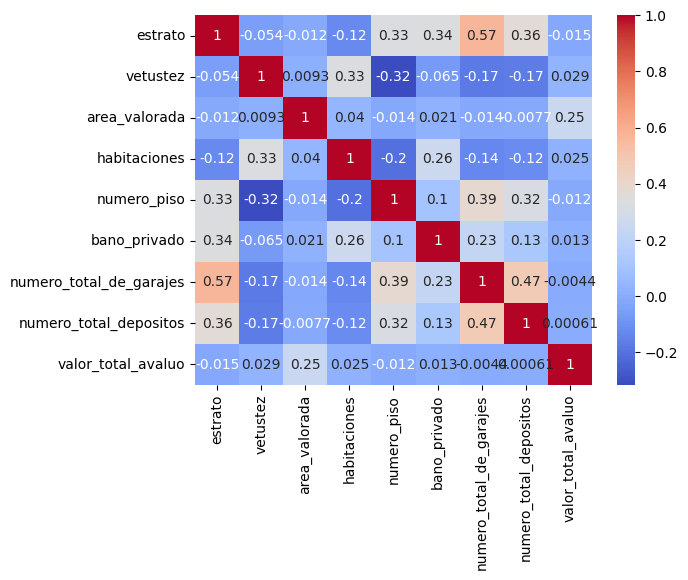

In [41]:
#@title Evaluar variables para incluir en el modelo
#Seleccionar principales variables numéricas para la matriz de correlación
numeric_variables = ['estrato', 'vetustez','area_valorada', 'habitaciones', 'numero_piso','bano_privado','numero_total_de_garajes', 'numero_total_depositos','valor_total_avaluo']

# Filtrar las columnas numéricas del DataFrame
Precios_train_numeric = Precios_train1[numeric_variables]

# Calcular la matriz de correlación
correlation_matrix = Precios_train_numeric.corr()

# Visualizar la matriz de correlación mediante un mapa de calor
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

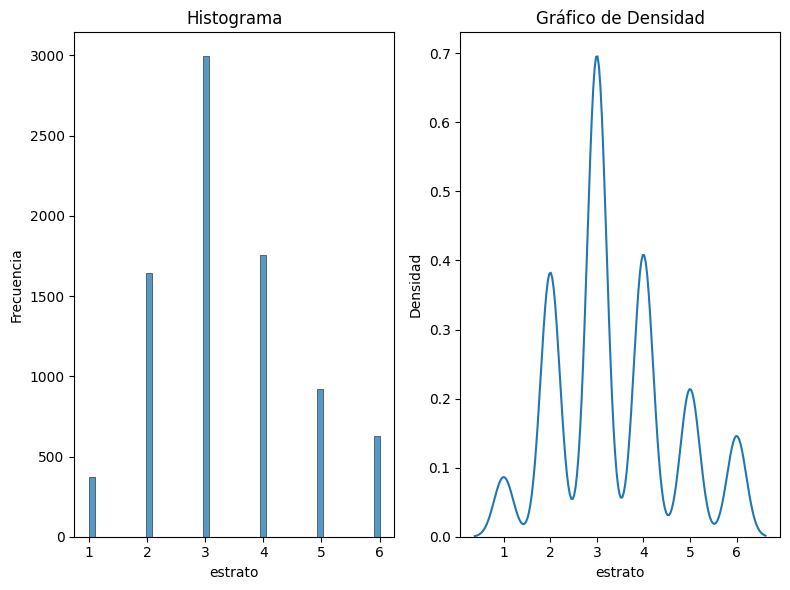

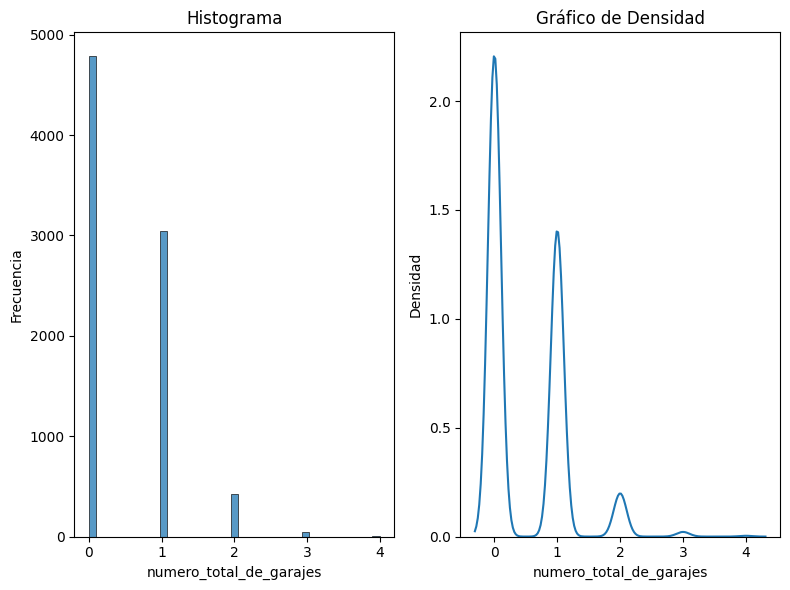

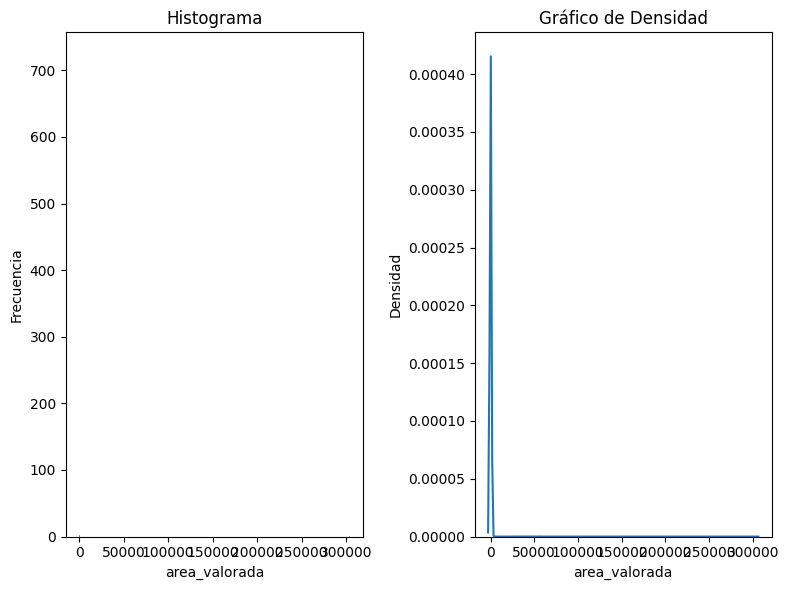

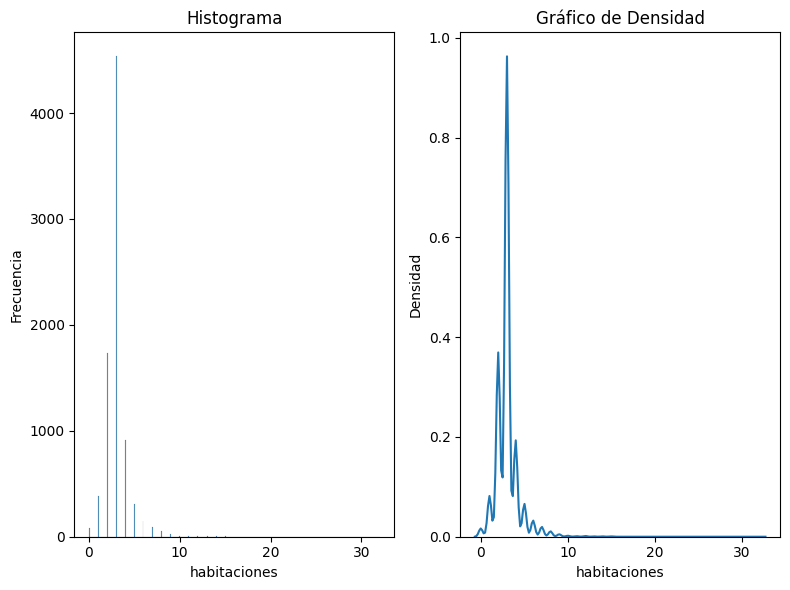

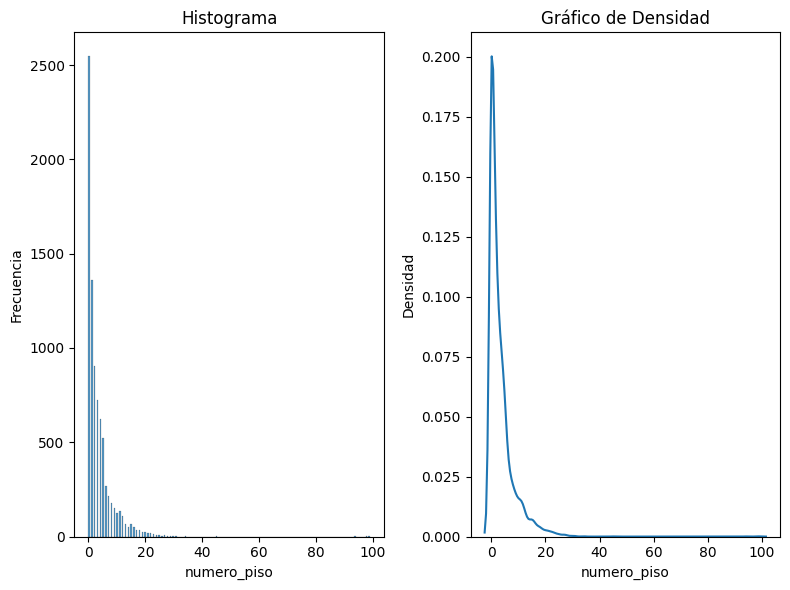

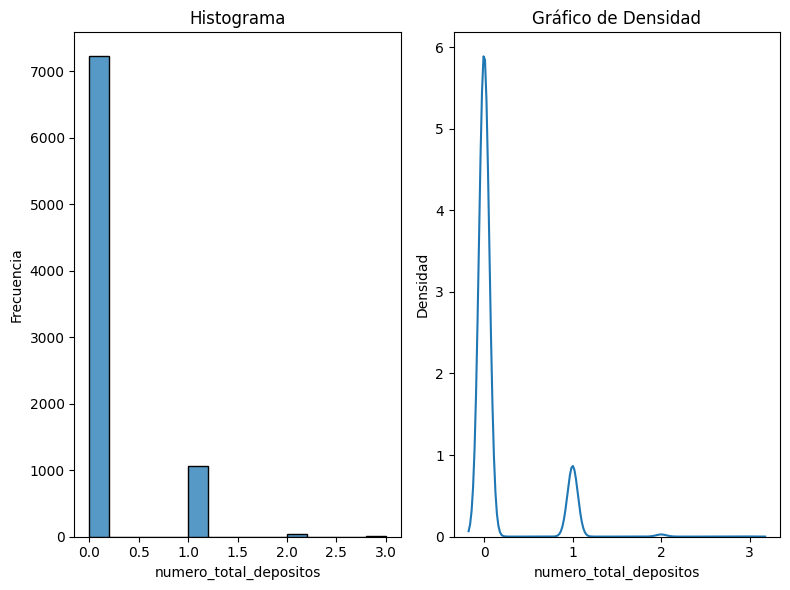

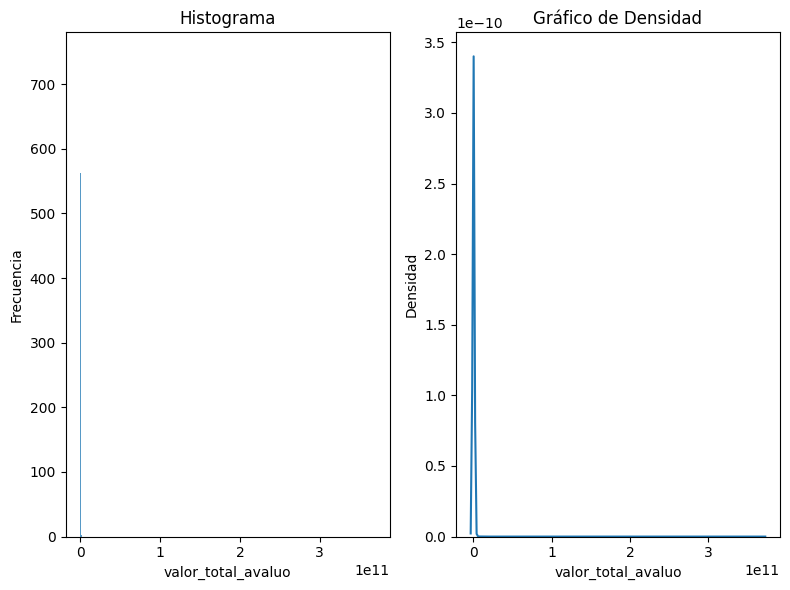

In [42]:
# Variables numéricas a analizar
numeric_variables = ['estrato', 'numero_total_de_garajes', 'area_valorada', 'habitaciones', 'numero_piso', 'numero_total_depositos', 'valor_total_avaluo']

# Crear un histograma y gráfico de densidad para cada variable
for variable in numeric_variables:
    plt.figure(figsize=(8, 6))

    # Histograma
    plt.subplot(1, 2, 1)
    sns.histplot(data=Precios_train1, x=variable, kde=False)
    plt.xlabel(variable)
    plt.ylabel('Frecuencia')
    plt.title('Histograma')

    # Gráfico de densidad
    plt.subplot(1, 2, 2)
    sns.kdeplot(data=Precios_train1, x=variable)
    plt.xlabel(variable)
    plt.ylabel('Densidad')
    plt.title('Gráfico de Densidad')

    plt.tight_layout()
    plt.show()

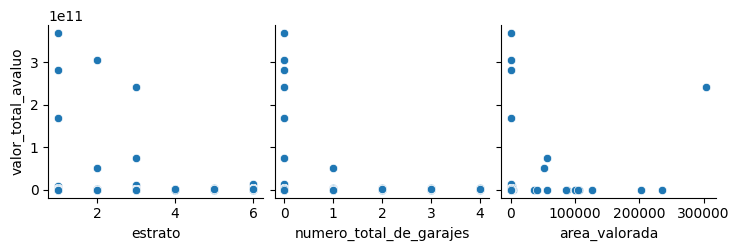

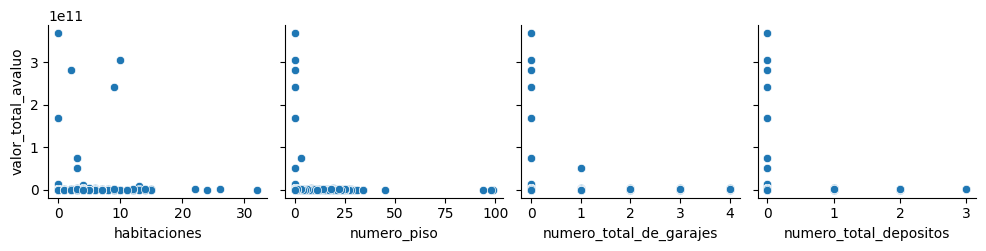

In [43]:
#para pintar graficos de dispersion y ver el comportamiento entre todas las variables explicativas y la variable
#valor(que es la variable que se quiere predecir), donde esta funcion recibe tres parametros, el primero es un dataframe con los datos, y los
#otros dos parametros x_vars y y_vars contienen una lista con los nombres de las variables que se quieren
#generar para los graficos de dispersion
sns.pairplot(Precios_train1, x_vars=['estrato', 'numero_total_de_garajes', 'area_valorada'], y_vars=['valor_total_avaluo'])
sns.pairplot(Precios_train1, x_vars=['habitaciones', 'numero_piso', 'numero_total_de_garajes', 'numero_total_depositos'], y_vars=['valor_total_avaluo'])
#sns.pairplot(h, x_vars=['autopistas', 'impuestos', 'profesores', 'status'], y_vars=['valor_total_avaluo'])

In [44]:
#@title Separar las características de entrada (X_train) y las etiquetas de salida (y_train) para utilizar las características para predecir o estimar el valor de la etiqueta.
X_train = Precios_train1.drop(['id','valor_total_avaluo'], axis=1)
# Codificación one-hot de variables categóricas
X_train_encoded = pd.get_dummies(X_train, columns=['municipio_inmueble','barrio','sector','estrato','barrio_legal','transporte','demanda_interes','alumbrado','nivel_equipamiento_comercial','alcantarillado_en_el_predio','acueducto_en_el_predio','gas_en_el_predio','energia_en_el_predio','telefono_en_el_predio','tipo_inmueble','rph', 'porteria', 'citofono', 'bicicletero', 'piscina', 'tanque_de_agua', 'club_house', 'garaje_visitantes', 'tipo_vigilancia','estructura', 'cubierta', 'fachada', 'iluminacion', 'ventilacion','calidad_acabados_pisos', 'calidad_acabados_muros', 'calidad_acabados_techos', 'calidad_acabados_madera', 'calidad_acabados_metal', 'calidad_acabados_banos', 'calidad_acabados_cocina'])
y_train = Precios_train1['valor_total_avaluo']

In [45]:
#@title **Traer datos de prueba**

# cuando es un archivo de csv se utiliza este codigo

downloaded = drive.CreateFile({'id': '1ZTkmlzp1u9WY656ZkIHGlnLWi6xFimLn'}) # replace the id with id of file you want to access
downloaded.GetContentFile('test_precios_vivienda.csv')
test= pd.read_csv('test_precios_vivienda.csv')
test

,Unnamed: 0,id,fecha_aprobación,objeto,motivo,proposito,tipo_avaluo,tipo_credito,tipo_subsidio,departamento_inmueble,municipio_inmueble,barrio,sector,direccion_inmueble_informe,alcantarillado_en_el_sector,acueducto_en_el_sector,gas_en_el_sector,energia_en_el_sector,telefono_en_el_sector,vias_pavimentadas,sardineles_en_las_vias,andenes_en_las_vias,estrato,barrio_legal,topografia_sector,condiciones_salubridad,transporte,demanda_interes,paradero,alumbrado,arborizacion,alamedas,ciclo_rutas,nivel_equipamiento_comercial,descripcion_general_sector,perspectivas_de_valorizacion,actualidad_edificadora,comportamiento_oferta_demanda,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,telefono_en_el_predio,tipo_inmueble,descripcion_tipo_inmueble,uso_actual,descripcion_uso_inmueble,clase_inmueble,descripcion_clase_inmueble,ocupante,sometido_a_propiedad_horizontal,altura_permitida,observaciones_altura_permitida,aislamiento_posterior,observaciones_aislamiento_posterior,aislamiento_lateral,observaciones_aislamiento_lateral,antejardin,observaciones_antejardin,indice_ocupacion,observaciones_indice_ocupacion,indice_construccion,observaciones_indice_construccion,predio_subdividido_fisicamente,unidades,contadores_agua,contadores_luz,accesorios,area_valorada,observaciones_generales_inmueble,condicion_ph,numero_piso,numero_de_edificios,area_actividad,uso_principal_ph,rph,porteria,citofono,bicicletero,piscina,tanque_de_agua,club_house,garaje_visitantes,teatrino,sauna,vigilancia_privada,tipo_vigilancia,administracion,vetustez,pisos_bodega,estructura,ajustes_sismoresistentes,cubierta,fachada,tipo_fachada,estructura_reforzada,danos_previos,material_de_construccion,detalle_material,iluminacion,ventilacion,irregularidad_planta,irregularidad_altura,observaciones_estructura,habitaciones,estar_habitacion,cuarto_servicio,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,jardin,zona_de_ropas,zona_verde_privada,local,oficina,bodega,observaciones_dependencias,estado_acabados_pisos,calidad_acabados_pisos,estado_acabados_muros,calidad_acabados_muros,estado_acabados_techos,calidad_acabados_techos,estado_acabados_madera,calidad_acabados_madera,estado_acabados_metal,calidad_acabados_metal,estado_acabados_banos,calidad_acabados_banos,estado_acabados_cocina,calidad_acabados_cocina,tipo_garaje,numero_total_de_garajes,total_cupos_parquedaro,numero_garaje_1,matricula_garaje_1,garaje_cubierto_1,garaje_doble_1,garaje_paralelo_1,garaje_servidumbre_1,numero_garaje_2,matricula_garaje_2,garaje_cubierto_2,garaje_doble_2,garaje_paralelo_2,garaje_servidumbre_2,numero_garaje_3,matricula_garaje_3,garaje_cubierto_3,garaje_doble_3,garaje_paralelo_3,garaje_servidumbre_3,numero_garaje_4,matricula_garaje_4,garaje_cubierto_4,garaje_doble_4,garaje_paralelo_4,garaje_servidumbre_4,numero_garaje_5,matricula_garaje_5,garaje_cubierto_5,garaje_doble_5,garaje_paralelo_5,garaje_servidumbre_5,tipo_deposito,numero_total_depositos,numero_deposito_1,matricula_inmobiliaria_deposito_1,numero_deposito_2,matricula_inmobiliaria_deposito_2,numero_deposito_3,matricula_inmobiliaria_deposito_3,numero_deposito_4,matricula_inmobiliaria_deposito_4,numero_deposito_5,matricula_inmobiliaria_deposito_5,observaciones_generales_construccion,metodo_valuacion_1,concepto_del_metodo_1,metodo_valuacion_2,concepto_del_metodo_2,metodo_valuacion_3,concepto_del_metodo_3,metodo_valuacion_4,concepto_del_metodo_4,metodo_valuacion_5,concepto_del_metodo_5,metodo_valuacion_6,concepto_del_metodo_6,metodo_valuacion_7,concepto_del_metodo_7,metodo_valuacion_8,concepto_del_metodo_8,metodo_valuacion_9,concepto_del_metodo_9,area_privada,valor_area_privada,area_garaje,valor_area_garaje,area_deposito,valor_area_deposito,area_terreno,valor_area_terreno,area_construccion,valor_area_construccion,area_otros,valor_area_otros,area_libre,valor_area_libre,valor_total_avaluo,valor_uvr,valor_avaluo_en_uvr,Longitud,Latitud
0,7811,11166,NaN,OriginaciÃ³n,CrÃ©dito hip

In [46]:
#@title Verificar la cantidad de valores nulos en cada columna
Nulos_test= test.isna().sum().sort_values(ascending=False)
Nulos_test.head(20)

tipo_subsidio                           1145
fecha_aprobación                         739
descripcion_uso_inmueble                  20
descripcion_tipo_inmueble                 19
descripcion_clase_inmueble                19
observaciones_generales_construccion       5
numero_garaje_1                            2
Latitud                                    1
garaje_cubierto_4                          0
garaje_cubierto_1                          0
garaje_doble_1                             0
garaje_paralelo_1                          0
garaje_servidumbre_1                       0
numero_garaje_2                            0
matricula_garaje_2                         0
garaje_cubierto_2                          0
garaje_doble_2                             0
garaje_servidumbre_4                       0
garaje_paralelo_2                          0
matricula_garaje_4                         0
dtype: int64

In [47]:
test1= test[['id', 'municipio_inmueble', 'barrio', 'sector', 'estrato', 'barrio_legal', 'transporte', 'demanda_interes', 'alumbrado', 'nivel_equipamiento_comercial', 'alcantarillado_en_el_predio', 'acueducto_en_el_predio', 'gas_en_el_predio', 'energia_en_el_predio', 'telefono_en_el_predio', 'tipo_inmueble', 'area_valorada', 'numero_piso', 'rph', 'porteria', 'citofono', 'bicicletero', 'piscina', 'tanque_de_agua', 'club_house', 'garaje_visitantes', 'tipo_vigilancia', 'vetustez', 'estructura', 'cubierta', 'fachada', 'iluminacion', 'ventilacion', 'habitaciones', 'closet', 'sala', 'comedor', 'bano_privado', 'bano_social', 'bano_servicio', 'cocina', 'estudio', 'balcon', 'terraza', 'patio_interior', 'zona_de_ropas', 'calidad_acabados_pisos', 'calidad_acabados_muros', 'calidad_acabados_techos', 'calidad_acabados_madera', 'calidad_acabados_metal', 'calidad_acabados_banos', 'calidad_acabados_cocina', 'numero_total_de_garajes', 'numero_total_depositos', 'valor_total_avaluo']]
test1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1286 entries, 0 to 1285
Data columns (total 56 columns):
 #   Column                        Non-Null Count  Dtype 
---  ------                        --------------  ----- 
 0   id                            1286 non-null   int64 
 1   municipio_inmueble            1286 non-null   object
 2   barrio                        1286 non-null   object
 3   sector                        1286 non-null   object
 4   estrato                       1286 non-null   object
 5   barrio_legal                  1286 non-null   object
 6   transporte                    1286 non-null   object
 7   demanda_interes               1286 non-null   object
 8   alumbrado                     1286 non-null   object
 9   nivel_equipamiento_comercial  1286 non-null   object
 10  alcantarillado_en_el_predio   1286 non-null   object
 11  acueducto_en_el_predio        1286 non-null   object
 12  gas_en_el_predio              1286 non-null   object
 13  energia_en_el_pred

In [48]:
#@title Convertir a tipo numérico las columnas que deben ir en este tipo de dato y eliminar los nulos
test1['vetustez'] = pd.to_numeric(test1['vetustez'], errors='coerce')
test1['habitaciones'] = pd.to_numeric(test1['habitaciones'], errors='coerce')
test1['valor_total_avaluo'] = pd.to_numeric(test1['valor_total_avaluo'], errors='coerce')
test1['area_valorada'] = pd.to_numeric(test1['area_valorada'], errors='coerce')
test1['numero_piso'] = pd.to_numeric(test1['numero_piso'], errors='coerce')
test1['numero_total_de_garajes'] = pd.to_numeric(test1['numero_total_de_garajes'], errors='coerce')
test1['numero_total_depositos'] = pd.to_numeric(test1['numero_total_depositos'], errors='coerce')
# Eliminar las filas con valores no numéricos en las columnas de formato numerico
test1 = test1.dropna(subset=['vetustez', 'habitaciones','valor_total_avaluo','area_valorada','numero_piso','numero_total_de_garajes','numero_total_depositos'])

In [49]:
#@title Teniendo en cuenta que hay varios campos con tipo de dato objeto pero que deben ser entero, se crea un diccionario de tipos de dato a convertir
dtype_dict = {
    'closet': int,
    'sala':int,
    'comedor':int,
    'bano_privado':int,
}
# Convertir las columnas al tipo de dato especificado en el diccionario
test1 = test1.astype(dtype_dict)

In [50]:
test1

,id,municipio_inmueble,barrio,sector,estrato,barrio_legal,transporte,demanda_interes,alumbrado,nivel_equipamiento_comercial,alcantarillado_en_el_predio,acueducto_en_el_predio,gas_en_el_predio,energia_en_el_predio,telefono_en_el_predio,tipo_inmueble,area_valorada,numero_piso,rph,porteria,citofono,bicicletero,piscina,tanque_de_agua,club_house,garaje_visitantes,tipo_vigilancia,vetustez,estructura,cubierta,fachada,iluminacion,ventilacion,habitaciones,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,zona_de_ropas,calidad_acabados_pisos,calidad_acabados_muros,calidad_acabados_techos,calidad_acabados_madera,calidad_acabados_metal,calidad_acabados_banos,calidad_acabados_cocina,numero_total_de_garajes,numero_total_depositos,valor_total_avaluo
0,11166,MEDELLIN,LOMA DE LOS BERNAL,Urbano,5,Si,Bueno,Media,Si,Bueno,Si,Si,Si,Si,Si,Apartamento,64.59,24.0,Si,Si,Si,No,Si,Si,No,Si,24 Horas,2,Tradicional,Placa concreto imp.,Ladrillo a la vista,Bueno,Bueno,2.0,2,1,1,1,1,0,1,0,1,0,0,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,1.0,1,332032000.0
2,500,CIENAGA,NANCY POLO ROVIRA,Urbano,2,No,Bueno,Débil,Si,Bueno,Si,Si,Si,Si,No,Casa,80.00,0.0,0,0,0,0,0,0,0,0,0,29,Muro de carga,Teja fibrocemento,Concreto Texturado,Bueno,Bueno,3.0,0,1,1,0,1,0,1,0,0,1,1,1,Normal,Normal,Sin Acabados,Normal,Normal,Sencillo,Sencillo,0.0,0,72000000.0
3,12884,MELGAR,VDA. CHIMBI,Rural,5,Si,Bueno,Media,No,Bueno,Si,Si,0,Si,No,Casa,209.42,1.0,Si,Si,No,No,Si,No,No,Si,24 Horas,15,Tradicional,Teja de barro,PaÃ±ete y pintura,Bueno,Bueno,3.0,3,1,1,2,1,0,1,0,1,1,1,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,0.0,0,448995800.0
5,14612,BUGA,ALTOS DE GUADALAJARA,Urbano,3,Si,Bueno,Media,Si,Bueno,Si,Si,Si,Si,No,Casa,138.16,0.0,0,0,0,0,0,0,0,0,0,19,Mamposteria Estructural,Teja fibrocemento,Graniplast,Bueno,Bueno,3.0,3,1,1,2,1,1,1,0,1,0,2,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,0.0,0,150859296.0
6,11584,PITALITO,SOLARTE,Urbano,3,Si,Bueno,Media,Si,Bueno,Si,Si,No,Si,No,Casa,131.60,1.0,Si,Si,Si,No,Si,Si,No,Si,0,0,Tradicional,Teja fibrocemento,Graniplast,Bueno,Bueno,3.0,3,1,1,1,1,0,1,1,1,0,1,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,0.0,0,243164280.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1281,7139,ENVIGADO,ChingÃ¼Ã­,Urbano,4,Si,Bueno,Fuerte,Si,Regular Malo,Si,Si,Si,Si,Si,Apartamento,57.18,5.0,Si,Si,No,No,Si,No,No,Si,24 Horas,1,Muro de carga,Placa concreto imp.,Otros,Bueno,Bueno,2.0,2,1,1,2,0,0,1,0,1,0,0,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,1.0,0,278310000.0
1282,16017,SABANETA,CENTRO,Urbano,4,Si,Bueno,Media,Si,Bueno,Si,Si,Si,Si,No,Apartamento,64.62,6.0,Si,Si,Si,No,No,Si,No,Si,24 Horas,0,Mamposteria Estructural,Placa concreto imp.,Ladrillo a la vista,Bueno,Bueno,3.0,3,1,1,1,1,0,1,0,1,0,0,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,1.0,1,271740200.0
1283,13347,PEREIRA,SANTA CLARA DE LAS VILLAS,Urbano,5,Si,Bueno,Media,Si,Bueno,Si,Si,Si,Si,Si,Casa,121.20,3.0,Si,Si,Si,No,Si,Si,No,Si,24 Horas,11,Tradicional,Teja fibrocemento,Graniplast,Bueno,Bueno,4.0,3,1,1,3,1,0,1,0,1,1,1,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,1.0,0,289103749.0
1284,7520,"BOGOTÃ, D. C.",Espartillal,Urbano,5,Si,Bueno,Media,Si,Muy bueno,Si,Si,Si,Si,Si,Apartamento,160.03,6.0,Si,Si,Si,No,No,Si,No,Si,24 Horas,45,Mamposteria Estructural,Placa concreto imp.,Otros,Bueno,Bueno,3.0,3,1,1,1,2,1,1,0,0,0,0,1,Normal,Normal,Normal,Normal,Normal,Normal,Integral,1.0,0,665724800.0


In [51]:
#estadistica descriptiva base de entrenamiento
test1.describe()

,id,area_valorada,numero_piso,vetustez,habitaciones,closet,sala,comedor,bano_privado,bano_social,bano_servicio,cocina,estudio,balcon,terraza,patio_interior,zona_de_ropas,numero_total_de_garajes,numero_total_depositos,valor_total_avaluo
count,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,910.000000,9.100000e+02
mean,11457.784615,151.786986,3.307692,14.296703,3.000000,1.842857,1.060440,1.025275,1.079121,1.007692,0.126374,1.062637,0.227473,0.523077,0.224176,0.404396,0.971429,0.503297,0.130769,4.573240e+09
std,4078.582146,1726.202031,4.522994,14.213827,1.295673,1.401919,0.368859,0.378781,0.945316,0.699635,0.332453,0.368492,0.429794,0.660879,0.474044,0.588842,0.495588,0.614717,0.350135,1.174177e+11
min,98.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,8264.250000,56.832500,0.000000,2.000000,2.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.197975e+08
50%,11673.000000,75.535000,2.000000,10.000000,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.758380e+08
75%,14771.000000,107.837500,4.000000,24.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,2.918315e+08
max,18330.000000,52128.000000,28.000000,71.000000,13.000000,6.000000,5.000000,5.000000,13.000000,4.000000,1.000000,5.000000,2.000000,4.000000,4.000000,4.000000,10.000000,4.000000,2.000000,3.530625e+12


In [52]:
#@title Separar las características de entrada (X_test) y las etiquetas de salida (y_test) para utilizar las características para predecir o estimar el valor de la etiqueta.
X_test = test1.drop(['id','valor_total_avaluo'], axis=1)
# Obtener las columnas comunes entre X_train y X_test
common_columns = list(set(X_train.columns).intersection(set(X_test.columns)))
# Filtrar X_test para mantener solo las columnas comunes
X_test = X_test[common_columns]
y_test = test1['valor_total_avaluo']

# **Modelo de regresión lineal**
El proceso de construccion de un modelo de regresion se divide en dos partes, la primera es la etapa de entrenamiento y la segunda la etapa de evaluacion (df_train) y (df_test)

> Bloc con sangría



In [53]:
# Concatenar X_train y X_test
combined_data = pd.concat([X_train, X_test], axis=0)

# Realizar la codificación one-hot en ambos conjuntos combinados
combined_encoded = pd.get_dummies(combined_data)

# Dividir nuevamente en conjuntos de entrenamiento y prueba
X_train_encoded = combined_encoded[:len(X_train)]
X_test_encoded = combined_encoded[len(X_train):]

In [54]:
#@title **Entrenar modelo de regresión lineal**
# Crear una instancia del modelo de regresión lineal
model = LinearRegression()

# Entrenar el modelo con los datos de entrenamiento
model.fit(X_train_encoded, y_train)

LinearRegression()

In [55]:
# Eliminar muestras con valores faltantes en X_test_encoded
X_test_encoded = X_test_encoded.dropna()
y_test = y_test[X_test_encoded.index]

In [59]:
#@title **Evaluar el modelo**
# Predecir los valores de salida para los datos de prueba
y_pred = model.predict(X_test_encoded)
# Calcular el error porcentual medio absoluto (MAPE)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape}")

MAPE: 2.4819615968588554e+30


In [57]:
"""#grafico de dispersion nos muestra el comportamiento de los datos deacuardo con dos variables distintas
#para ver la relacion entre la variable que vamos a predecir que es el precio y las demas variables
# Crear rangos para la variable 'habitaciones'
bins = [0, 2, 4, 6, 8, 10]  # Definir los límites de los rangos
labels = ['0-2', '2-4', '4-6', '6-8', '8-10']  # Etiquetas de los rangos
# Agregar una columna con los rangos a los datos
Precios_train1['habitaciones_range'] = pd.cut(Precios_train1['habitaciones'], bins=bins, labels=labels)
# Calcular el promedio de 'valor_total_avaluo' para cada rango de habitaciones
grouped_data = Precios_train1.groupby('habitaciones_range')['valor_total_avaluo'].mean()
# Graficar los promedios por rango de habitaciones
plt.bar(grouped_data.index, grouped_data)
plt.title("Promedio de precio por rango de habitaciones")
plt.xlabel("Rango de habitaciones")
plt.ylabel("Precio promedio ($)")
plt.show()"""

'#grafico de dispersion nos muestra el comportamiento de los datos deacuardo con dos variables distintas\n#para ver la relacion entre la variable que vamos a predecir que es el precio y las demas variables\n# Crear rangos para la variable \'habitaciones\'\nbins = [0, 2, 4, 6, 8, 10]  # Definir los límites de los rangos\nlabels = [\'0-2\', \'2-4\', \'4-6\', \'6-8\', \'8-10\']  # Etiquetas de los rangos\n# Agregar una columna con los rangos a los datos\nPrecios_train1[\'habitaciones_range\'] = pd.cut(Precios_train1[\'habitaciones\'], bins=bins, labels=labels)\n# Calcular el promedio de \'valor_total_avaluo\' para cada rango de habitaciones\ngrouped_data = Precios_train1.groupby(\'habitaciones_range\')[\'valor_total_avaluo\'].mean()\n# Graficar los promedios por rango de habitaciones\nplt.bar(grouped_data.index, grouped_data)\nplt.title("Promedio de precio por rango de habitaciones")\nplt.xlabel("Rango de habitaciones")\nplt.ylabel("Precio promedio ($)")\nplt.show()'

In [58]:
#@title Debido al alto indice MAPE arrojado en el primer ejercicio, con el fin de descartar valores atipicos se realizará el cálculo del IQR
# Calcular el rango intercuartílico (IQR)
Q1 = np.percentile(y_pred, 25)
Q3 = np.percentile(y_pred, 75)
IQR = Q3 - Q1

# Definir los límites inferior y superior para identificar los valores atípicos
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrar los valores atípicos en y_pred y y_test
filtered_indices = (y_pred >= lower_bound) & (y_pred <= upper_bound)
y_pred_filtered = y_pred[filtered_indices]
y_test_filtered = y_test[filtered_indices]

# Calcular las métricas de evaluación con los datos filtrados
mape = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)

print("MAPE:", mape)

RMSE: 2.546513662779705e+17
MAE: 2.546513662779704e+17
MAPE: 1618588493.0019016


# **Interpretación de Resultados y conclusiones generales**
Para realizar el análisis y modelado de predicción de precios de vivienda utilizando un el de datos de entrenamiento se aplicaron diversas técnicas de limpieza, preparación y transformación de los datos con el objetivo de construir un modelo de regresión lineal para predecir el valor total de avalúo de las viviendas.

Sin embargo, los resultados obtenidos del modelo no cumplieron con las expectativas y mostraron un desempeño insatisfactorio en términos de la métrica MAPE, el cual arrojó un valor demasiado alto, lo que permite concluir que el modelo no captura de manera precisa la relación entre las características de las viviendas y sus precios. Esto se puede estar presentando por algunas de las siguientes causas:
- Que los datos después de haber sido limpiados y tratados, aún no son confiables para predecir de manera certera los precios.
- La falta de correlación en los datos registrados en las bases de datos frente al precio de cada inmueble.
- La presencia de valores atípicos en diferentes variables

Al respecto, se requiere una mayor exploración, análisis y mejora del modelo para lograr una mayor precisión en las predicciones. Se podrían  aplicar técnicas de selección de características por medio de análisis estadístico específico, así como una mayor comprensión del dominio y la naturaleza de los datos.

En conclusión, aunque los resultados no fueron satisfactorios, el proceso de análisis y modelado de predicción realizado es una buena base para realizar un análisis más exhaustivo, explorar diferentes enfoques y técnicas para lograr un modelo más preciso y confiable en la predicción de los precios de vivienda.